In [1]:
from importlib import reload
import numpy as np
import xarray as xr
import pandas as pd

import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import colors

import matplotlib.gridspec as gridspec
import seaborn as sns
import scienceplots
import cartopy as cart

from datetime import datetime

import gsw

import h3
from h3.unstable import vect

import sys
import pickle
from collections import deque
import tqdm

%config InlineBackend.figure_format = 'retina'

sys.path.append('/nethome/4302001/NASTMW_DIC/tools')
import plotting
import event_identification
import preprocess_timeseries

/nethome/4302001/miniconda3/lib/python3.9/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


In [2]:
traj_dir = "/storage/shared/oceanparcels/output_data/data_Daan/EDW_trajectories/"
mask_dir = "/storage/shared/oceanparcels/output_data/data_Daan/EDW_trajectory_masks/"

In [3]:
# binned_events_per_year = {}
# for year in range(1995, 2016):
#     print(year)
#     events = event_identification.open_from_pickle_and_link(f"EDW_wfluxes_B_{year}-09-01_1095d_dt90_odt24",
#                                                         preprocess={"fluxes": False,
#                                                                     "sequestration": False,
#                                                                     "mask": False,
#                                                                     "in_edw": False
#                                                                     })
#     mask_ds = xr.open_dataset(mask_dir + f"EDW_wfluxes_B_{year}-09-01_1095d_dt90_odt24_masks.nc")
#     event_identification.check_mask_ds_attrs(events.ds, mask_ds)
#     event_identification.check_events_mask_trajs(events, mask_ds)

#     true_template = (events.ds.DIC*0+1).fillna(1).astype(bool)
#     start_in_edw = true_template * mask_ds.start_in_edw

#     returns_to_edw_1y = mask_ds.forw_persistent_mask * start_in_edw
#     stays_in_edw_1y = mask_ds.forw_persistent_mask_full * start_in_edw

#     filter = event_identification.multi_event_filter_from_ds(events.event_dict, stays_in_edw_1y,
#                                                             last_index=365, last_index_inclusion_mode="any", mode="all")

#     print(f"From the particles initialized in september {year}, the amount that stay persistenly in the EDW is: ")
#     print(f"{int(np.sum(mask_ds.forw_persistent_mask_full))}/{int(np.sum(mask_ds.start_in_edw))} ({np.sum(mask_ds.forw_persistent_mask_full)/np.sum(mask_ds.start_in_edw)*100:.2f}%)")
#     binned_events_per_year[year] = event_identification.bin_aggregate_events(events.aggregate_event_dict,
#                                                                              filter,
#                                                                              vars_to_analyze=["cs_DIC_total", "cs_DIC_bio_soft", "cs_DIC_bio_carbonate", "cs_DIC_diff"], normalize=True)


In [4]:
timescale_dir = "/storage/shared/oceanparcels/output_data/data_Daan/EDW_multiyear_timescales/"


experiments = [
    "start_in_edw_any",
    "backw_start_in_edw_any",
    "return_to_edw_1y",
    "stay_in_edw_1y",
    "densification_005_1y_after_2y",
    "densification_005_1y_after_3y",
    "densification_001_1y_after_2y",
    "densification_001_1y_after_3y",
    "densification_0_1y_after_2y",
    "densification_0_1y_after_3y",
    "reached_mixed",
    "reached_mixed_back_in_edw",
    "reached_mixed_not_in_edw",
    "reached_mixing",
    "reached_mixing_back_in_edw",
    "reached_mixing_not_in_edw",
    "subduction_after_1y",
    "subduction_after_2y",
    "subduction_after_3y"
]

In [5]:
experiments_title = {
    "start_in_edw_any" : "All trajectories (forward)",
    "backw_start_in_edw_any" : "All trajectories (backward)",
    "return_to_edw_1y" : "Returned to NASTMW after 1 year",
    "stay_in_edw_1y" : "Stayed in NASTMW for 1 year",
    "densification_005_1y_after_2y" : "Densification for 1 year (after 2 years — 0.05 kg/m3)",
    "densification_005_1y_after_3y" : "Densification for 1 year (after 3 years — 0.05 kg/m3)",
    "densification_001_1y_after_2y" : "Densification for 1 year (after 2 years — 0.01 kg/m3)",
    "densification_001_1y_after_3y" : "Densification for 1 year (after 3 years — 0.01 kg/m3)",
    "densification_0_1y_after_2y" : "Densification for 1 year (after 2 years — 0 kg/m3)",
    "densification_0_1y_after_3y" : "Densification for 1 year (after 3 years — 0 kg/m3)",
    "reached_mixed" : "Reached the mixed layer in 1y",
    "reached_mixed_back_in_edw" : "Reached the mixed layer in 1y (back in NASTMW)",
    "reached_mixed_not_in_edw" : "Reached the mixed layer in 1y (not in NASTMW)",
    "reached_mixing" : "Reached the mixing layer in 1y",
    "reached_mixing_back_in_edw" : "Reached the mixing layer in 1y (back in NASTMW)",
    "reached_mixing_not_in_edw" : "Reached the mixing layer in 1y (not in NASTMW)",
    "subduction_after_1y" : "Subducted after 1 year",
    "subduction_after_2y" : "Subducted after 2 years",
    "subduction_after_3y" : "Subducted after 3 years"
}

In [6]:
binned_events_per_year_dict = {}
for experiment in tqdm.tqdm(experiments):
    if "subduction" in experiment:
        sign = "-"
    elif "backw" in experiment:
        sign = "-"
    else:
        sign = ""
    
    with open(timescale_dir + f"EDW_wfluxes_B_1095d_dt{sign}90_odt24_{experiment}_binned_events_per_year.pkl", "rb") as f:
        binned_events_per_year_dict[experiment] = pickle.load(f)

100%|██████████| 19/19 [06:05<00:00, 19.25s/it]


In [7]:
binned_events_per_year_dict["return_to_edw_1y"].keys()

dict_keys([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015])

In [8]:
binned_events_per_year_dict.keys()

dict_keys(['start_in_edw_any', 'backw_start_in_edw_any', 'return_to_edw_1y', 'stay_in_edw_1y', 'densification_005_1y_after_2y', 'densification_005_1y_after_3y', 'densification_001_1y_after_2y', 'densification_001_1y_after_3y', 'densification_0_1y_after_2y', 'densification_0_1y_after_3y', 'reached_mixed', 'reached_mixed_back_in_edw', 'reached_mixed_not_in_edw', 'reached_mixing', 'reached_mixing_back_in_edw', 'reached_mixing_not_in_edw', 'subduction_after_1y', 'subduction_after_2y', 'subduction_after_3y'])

In [9]:
def binned_events_multiyear_aggregate(binned_events_per_year, year_range=np.arange(1995, 2016)):
    y0 = year_range[0]
    n_years = len(binned_events_per_year.keys())
    n_bins = len(binned_events_per_year[y0]["cs_DIC_total"]["binned_events"])

    binned_events = {year: {} for year in binned_events_per_year[y0]}
    for key in binned_events.keys():
        # print(key)
        binned_events[key]["binned_events"] = {bin: [] for bin in binned_events_per_year[y0][key]["binned_events"]}
        binned_events[key]["binned_events_normed"] = {bin: [] for bin in binned_events_per_year[y0][key]["binned_events_normed"]}
        binned_events[key]["tot_pos_diff_arr"] = np.zeros((n_years, n_bins))
        binned_events[key]["tot_pos_diff_agg"] = np.zeros(n_bins)
        binned_events[key]["tot_neg_diff_arr"] = np.zeros((n_years, n_bins))
        binned_events[key]["tot_neg_diff_agg"] = np.zeros(n_bins)
        binned_events[key]["total_diff_arr"] = np.zeros((n_years, n_bins))
        binned_events[key]["total_diff_agg"] = np.zeros(n_bins)
        binned_events[key]["bins_edges"] = binned_events_per_year[y0][key]["bins_edges"]
        binned_events[key]["bins_edges_bounds"] = binned_events_per_year[y0][key]["bins_edges_bounds"]

        if binned_events_per_year[y0][key]["binned_constits"] is not None:
            binned_events[key]["binned_constits"] = {constit_key: {bin : [] for bin in np.arange(n_bins)} for constit_key in binned_events_per_year[y0][key]["binned_constits"]}

        for yearidx, year in enumerate(binned_events_per_year.keys()):
            for bin in binned_events_per_year[year][key]["binned_events"]:
                binned_events[key]["binned_events"][bin].append(np.array(binned_events_per_year[year][key]["binned_events"][bin]))
                binned_events[key]["binned_events_normed"][bin].append(np.array(binned_events_per_year[year][key]["binned_events_normed"][bin]))
                binned_events[key]["tot_pos_diff_arr"][yearidx, bin] = binned_events_per_year[year][key]["tot_pos_diff"][bin]
                binned_events[key]["tot_neg_diff_arr"][yearidx, bin] = binned_events_per_year[year][key]["tot_neg_diff"][bin]
                binned_events[key]["total_diff_arr"][yearidx, bin] = binned_events_per_year[year][key]["total_diff"][bin]
            if binned_events_per_year[year][key]["binned_constits"] is not None:
                for constit_key in binned_events_per_year[year][key]["binned_constits"]:
                    for bin in np.arange(n_bins):
                        binned_events[key]["binned_constits"][constit_key][bin].append(binned_events_per_year[year][key]["binned_constits"][constit_key][bin])

        
        for bin in binned_events[key]["binned_events"]:
            binned_events[key]["binned_events"][bin] = np.concatenate(binned_events[key]["binned_events"][bin])
            binned_events[key]["binned_events_normed"][bin] = np.concatenate(binned_events[key]["binned_events_normed"][bin])
            binned_events[key]["tot_pos_diff_agg"][bin] = np.sum(binned_events[key]["tot_pos_diff_arr"][:, bin])
            binned_events[key]["tot_neg_diff_agg"][bin] = np.sum(binned_events[key]["tot_neg_diff_arr"][:, bin])
            binned_events[key]["total_diff_agg"][bin] = np.sum(binned_events[key]["total_diff_arr"][:, bin])

        if binned_events_per_year[y0][key]["binned_constits"] is not None:
            for constit_key in binned_events_per_year[y0][key]["binned_constits"]:
                for inner_bin in np.arange(n_bins):
                    binned_events[key]["binned_constits"][constit_key][inner_bin] = np.concatenate(binned_events[key]["binned_constits"][constit_key][inner_bin])
            
    return binned_events

In [10]:
binned_events_experiments_dict = {
    experiment: binned_events_multiyear_aggregate(
        binned_events_per_year_dict[experiment],
        year_range=(np.arange(1996, 2016) if "subduction_after_1y" in experiment else 
                    np.arange(1997, 2016) if "subduction_after_2y" in experiment else 
                    np.arange(1998, 2016) if "subduction_after_3y" in experiment else
                    np.arange(1996, 2016) if "backw" in experiment else
                    np.arange(1995, 2016)) # default
    )
    for experiment in binned_events_per_year_dict
}

In [11]:
fig_titles = {"start_in_edw_any" : "All trajectories (forward)",
              "backw_start_in_edw_any" : "All trajectories (backward)",
              "subduction_after_1y" : "Subduction",
              "stay_in_edw_1y" : "Persistence",
              "reached_mixing_back_in_edw" : "Ventilation",
              "densification_001_1y_after_2y" : "Export",
              "subduction_after_2y" : "Subduction over 2 years",
              "subduction_after_3y" : "Subduction over 3 years",
              "densification_0_1y_after_2y" : "Export (using $\Delta \sigma = 0 $ kg m$^{-3}$)",
              "densification_005_1y_after_2y" : "Export (using $\Delta \sigma = 0.05 $ kg m$^{-3}$)",
              }

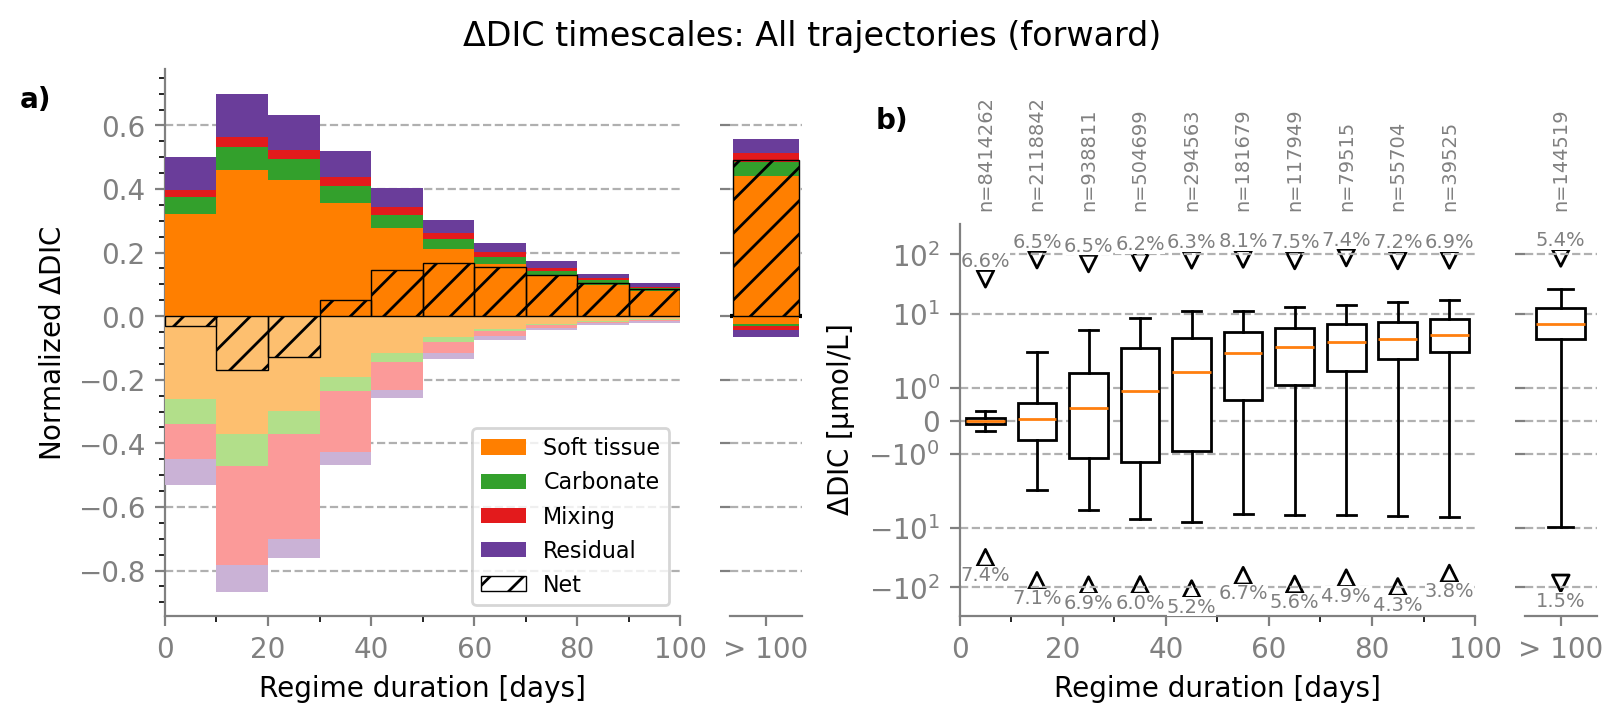

In [12]:
reload(event_identification)
experiment = "start_in_edw_any"
fig = event_identification.plot_event_distribution(binned_events_experiments_dict[experiment]["cs_DIC_total"]["binned_events"],
                                                binned_events_experiments_dict[experiment]["cs_DIC_total"]["tot_pos_diff_agg"],
                                                binned_events_experiments_dict[experiment]["cs_DIC_total"]["tot_neg_diff_agg"],
                                                binned_events_experiments_dict[experiment]["cs_DIC_total"]["total_diff_agg"],
                                                binned_events_experiments_dict[experiment]["cs_DIC_total"]["bins_edges_bounds"],
                                                binned_constits=binned_events_experiments_dict[experiment]["cs_DIC_total"]["binned_constits"],
                                                normalize_bars=True,
                                                title="", return_fig=True)
if experiment in fig_titles:
    fig.suptitle("ΔDIC timescales: " + fig_titles[experiment])
plt.savefig(f"figures/timescales_ensemble/timescales_{experiment}_cs_DIC_total.pdf", bbox_inches="tight")
plt.show()


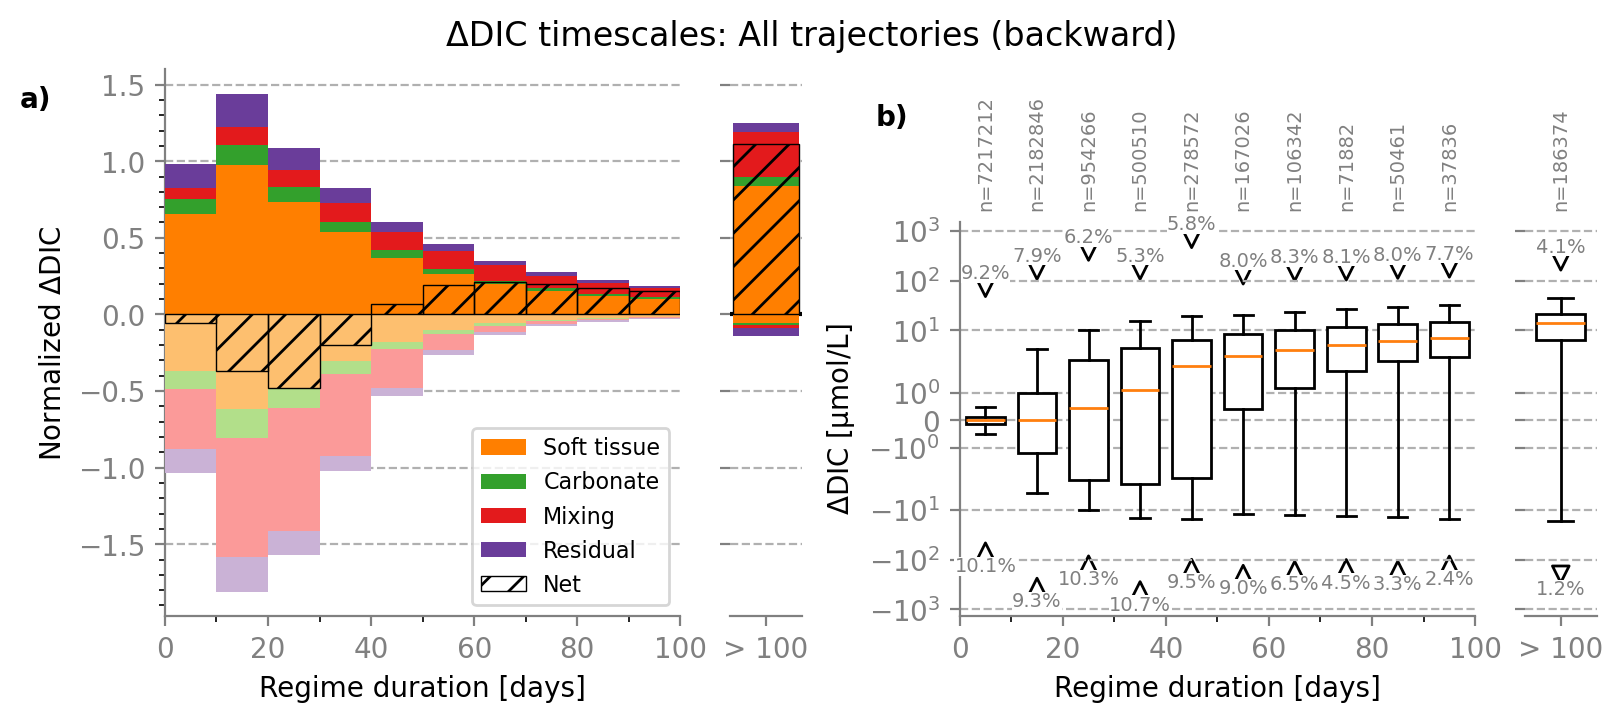

In [13]:
reload(event_identification)
experiment = "backw_start_in_edw_any"
fig = event_identification.plot_event_distribution(binned_events_experiments_dict[experiment]["cs_DIC_total"]["binned_events"],
                                                binned_events_experiments_dict[experiment]["cs_DIC_total"]["tot_pos_diff_agg"],
                                                binned_events_experiments_dict[experiment]["cs_DIC_total"]["tot_neg_diff_agg"],
                                                binned_events_experiments_dict[experiment]["cs_DIC_total"]["total_diff_agg"],
                                                binned_events_experiments_dict[experiment]["cs_DIC_total"]["bins_edges_bounds"],
                                                binned_constits=binned_events_experiments_dict[experiment]["cs_DIC_total"]["binned_constits"],
                                                normalize_bars=True,
                                                title="", return_fig=True)
if experiment in fig_titles:
    fig.suptitle("ΔDIC timescales: " + fig_titles[experiment])
plt.savefig(f"figures/timescales_ensemble/timescales_{experiment}_cs_DIC_total.pdf", bbox_inches="tight")
plt.show()


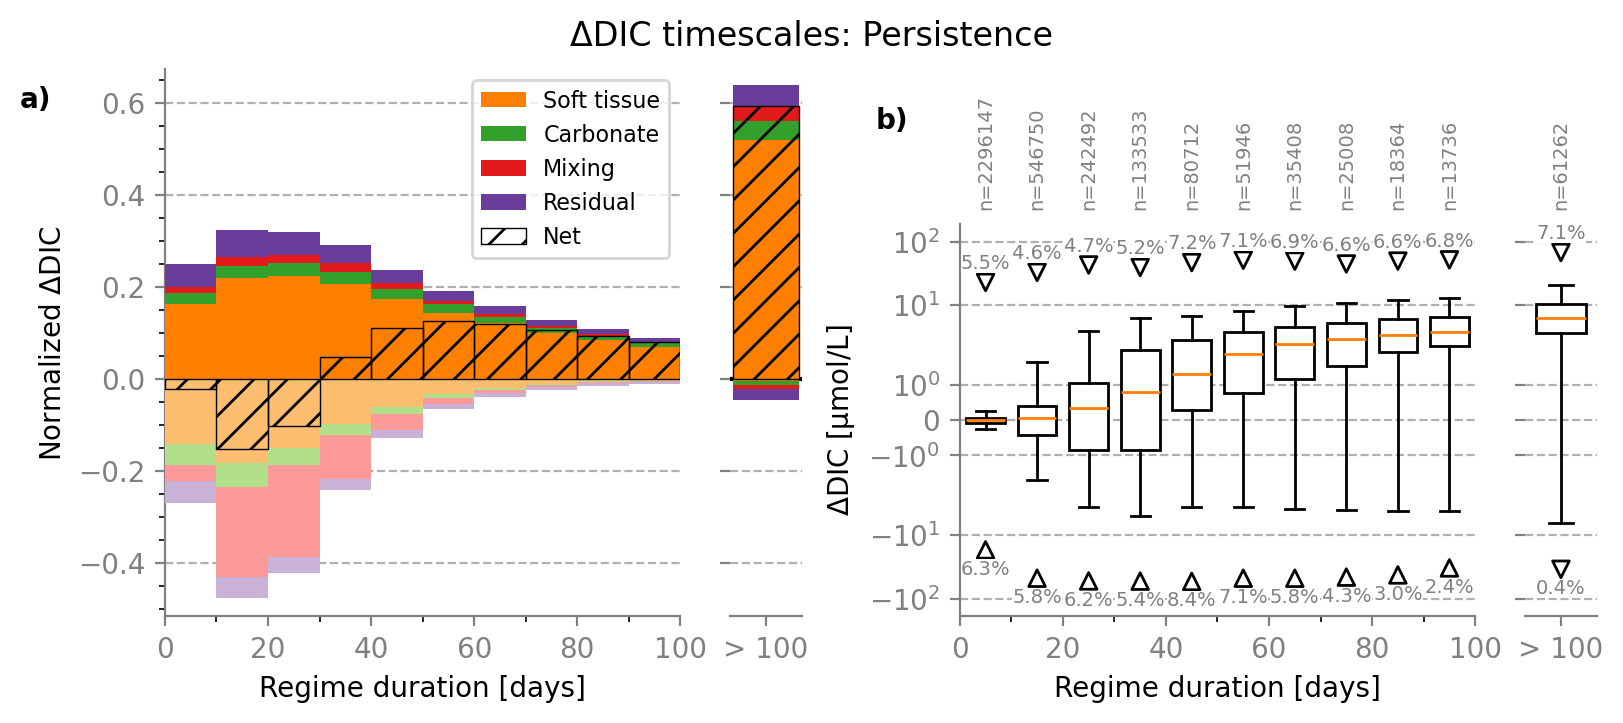

In [12]:
reload(event_identification)
experiment = "stay_in_edw_1y"
fig = event_identification.plot_event_distribution(binned_events_experiments_dict[experiment]["cs_DIC_total"]["binned_events"],
                                                binned_events_experiments_dict[experiment]["cs_DIC_total"]["tot_pos_diff_agg"],
                                                binned_events_experiments_dict[experiment]["cs_DIC_total"]["tot_neg_diff_agg"],
                                                binned_events_experiments_dict[experiment]["cs_DIC_total"]["total_diff_agg"],
                                                binned_events_experiments_dict[experiment]["cs_DIC_total"]["bins_edges_bounds"],
                                                binned_constits=binned_events_experiments_dict[experiment]["cs_DIC_total"]["binned_constits"],
                                                normalize_bars=True,
                                                title="", return_fig=True)
if experiment in fig_titles:
    fig.suptitle("ΔDIC timescales: " + fig_titles[experiment])
plt.show()
# plt.savefig(f"figures/timescales_ensemble/{experiment}_cs_DIC_total.pdf", bbox_inches="tight")

# Batch figure export

In [13]:
for experiment, binned_events_multiyears in tqdm.tqdm(binned_events_experiments_dict.items()):
    fig = event_identification.plot_event_distribution(binned_events_multiyears["cs_DIC_total"]["binned_events"],
                                                binned_events_multiyears["cs_DIC_total"]["tot_pos_diff_agg"],
                                                binned_events_multiyears["cs_DIC_total"]["tot_neg_diff_agg"],
                                                binned_events_multiyears["cs_DIC_total"]["total_diff_agg"],
                                                binned_events_multiyears["cs_DIC_total"]["bins_edges_bounds"],
                                                binned_constits=binned_events_multiyears["cs_DIC_total"]["binned_constits"],
                                                normalize_bars=True,
                                                title="", return_fig=True
                                                )
    if experiment in fig_titles:
        fig.suptitle("ΔDIC timescales: " + fig_titles[experiment])
    plt.savefig(f"figures/timescales_ensemble/timescales_{experiment}_cs_DIC_total.pdf", bbox_inches="tight")
    plt.close(fig)

100%|██████████| 17/17 [01:17<00:00,  4.57s/it]


In [14]:
for var, var_title in zip(["cs_DIC_bio_soft", "cs_DIC_bio_carbonate", "cs_DIC_diff"], ["Soft-tissue", "Carbonate", "Mixing"]):
    for experiment, binned_events_multiyears in tqdm.tqdm(binned_events_experiments_dict.items()):
        fig = event_identification.plot_event_distribution(binned_events_multiyears[var]["binned_events"],
                                                    binned_events_multiyears[var]["tot_pos_diff_agg"],
                                                    binned_events_multiyears[var]["tot_neg_diff_agg"],
                                                    binned_events_multiyears[var]["total_diff_agg"],
                                                    binned_events_multiyears[var]["bins_edges_bounds"],
                                                    normalize_bars=True,
                                                    # title=f"{var_title}: {experiments_title[experiment]}", 
                                                    return_fig=True, 
                                                    color_as=var)
        if experiment in fig_titles:
            fig.suptitle("ΔDIC timescales: " + fig_titles[experiment] + f" — {var_title} contribution")
        plt.savefig(f"figures/timescales_ensemble/timescales_{experiment}_{var}.pdf", bbox_inches="tight")
        plt.close()

  0%|          | 0/17 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:53<00:00,  3.13s/it]


In [15]:
experiments_sensitivity = [
    "stay_in_edw_1y",
    "reached_mixing_back_in_edw",
    "densification_001_1y_after_2y",
    "subduction_after_1y",
]

In [16]:
timescale_dir_sensitivity = "/storage/shared/oceanparcels/output_data/data_Daan/EDW_multiyear_timescales_sensitivity/"


In [17]:
for rw in tqdm.tqdm(['rw1', 'rw6', 'rw20'], desc="rw"):

    binned_events_per_year_dict_sensitivity = {}

    for experiment in tqdm.tqdm(experiments_sensitivity, desc="experiment", leave=False):
        if "subduction" in experiment:
            sign = "-"
        else:
            sign = ""
        
        with open(timescale_dir_sensitivity + f"EDW_wfluxes_B_1095d_dt{sign}90_odt24_{experiment}_binned_events_per_year_{rw}.pkl", "rb") as f:
            binned_events_per_year_dict_sensitivity[experiment] = pickle.load(f)


    binned_events_experiments_dict_sensitivity = {
        experiment: binned_events_multiyear_aggregate(
            binned_events_per_year_dict_sensitivity[experiment],
            year_range=(np.arange(1996, 2016) if "subduction_after_1y" in experiment else 
                    np.arange(1997, 2016) if "subduction_after_2y" in experiment else 
                    np.arange(1998, 2016) if "subduction_after_3y" in experiment else
                    np.arange(1995, 2016)) # default
    )
    for experiment in binned_events_per_year_dict_sensitivity}
    
    # reload(event_identification)
    # fig = event_identification.plot_event_distribution(binned_events_experiments_dict["return_to_edw_1y"]["cs_DIC_total"]["binned_events"],
    #                                                 binned_events_experiments_dict["return_to_edw_1y"]["cs_DIC_total"]["tot_pos_diff_agg"],
    #                                                 binned_events_experiments_dict["return_to_edw_1y"]["cs_DIC_total"]["tot_neg_diff_agg"],
    #                                                 binned_events_experiments_dict["return_to_edw_1y"]["cs_DIC_total"]["total_diff_agg"],
    #                                                 binned_events_experiments_dict["return_to_edw_1y"]["cs_DIC_total"]["bins_edges_bounds"],
    #                                                 binned_constits=binned_events_experiments_dict["return_to_edw_1y"]["cs_DIC_total"]["binned_constits"],
    #                                                 normalize_bars=True,
    #                                                 title=experiments_title[experiment], return_fig=True)
    # plt.show()
        # plt.savefig(f"figures/timescales_ensemble/{experiment}_cs_DIC_total.pdf", bbox_inches="tight")
    
    for experiment, binned_events_multiyears in binned_events_experiments_dict_sensitivity.items():
        fig = event_identification.plot_event_distribution(binned_events_multiyears["cs_DIC_total"]["binned_events"],
                                                    binned_events_multiyears["cs_DIC_total"]["tot_pos_diff_agg"],
                                                    binned_events_multiyears["cs_DIC_total"]["tot_neg_diff_agg"],
                                                    binned_events_multiyears["cs_DIC_total"]["total_diff_agg"],
                                                    binned_events_multiyears["cs_DIC_total"]["bins_edges_bounds"],
                                                    binned_constits=binned_events_multiyears["cs_DIC_total"]["binned_constits"],
                                                    normalize_bars=True,
                                                    title="", return_fig=True)
        if experiment in fig_titles:
            if rw == "rw1":
                fig.suptitle("ΔDIC timescales: " + fig_titles[experiment] + " — no smoothing")
            else:
                fig.suptitle("ΔDIC timescales: " + fig_titles[experiment] + f" — {rw[2:]}-day smoothing")
        plt.savefig(f"figures/timescales_ensemble_sensitivity/{rw}/timescales_{experiment}_cs_DIC_total_{rw}.pdf", bbox_inches="tight")
        plt.close()
    reload(event_identification)
    for var, var_title in zip(["cs_DIC_bio_soft", "cs_DIC_bio_carbonate", "cs_DIC_diff"], ["Soft-tissue", "Carbonate", "Mixing"]):
        for experiment, binned_events_multiyears in binned_events_experiments_dict_sensitivity.items():
            fig = event_identification.plot_event_distribution(binned_events_multiyears[var]["binned_events"],
                                                        binned_events_multiyears[var]["tot_pos_diff_agg"],
                                                        binned_events_multiyears[var]["tot_neg_diff_agg"],
                                                        binned_events_multiyears[var]["total_diff_agg"],
                                                        binned_events_multiyears[var]["bins_edges_bounds"],
                                                        normalize_bars=True,
                                                        title=f"", 
                                                        return_fig=True, 
                                                        color_as=var)
            if experiment in fig_titles:
                if rw == "rw1":
                    fig.suptitle("ΔDIC timescales: " + fig_titles[experiment] + f" — {var_title} contribution — no smoothing")
                else:
                    fig.suptitle("ΔDIC timescales: " + fig_titles[experiment] + f" — {var_title} contribution — {rw[2:]}-day smoothing")
            plt.savefig(f"figures/timescales_ensemble_sensitivity/{rw}/timescales_{experiment}_{var}_{rw}.pdf", bbox_inches="tight")
            plt.close()

rw:   0%|          | 0/3 [00:00<?, ?it/s]

rw: 100%|██████████| 3/3 [06:17<00:00, 125.98s/it]


# Exploration of individual events

In [ ]:
print("Median value of the total DIC change for persisting parcels in the EDW for 1 year:")
np.median(binned_events_experiments_dict["stay_in_edw_1y"]["cs_DIC_total"]["binned_events"][10])

Median value of the total DIC change for persisting parcels in the EDW for 1 year:


6.1658935546875